In [1]:
import tensorflow as tf
import numpy as np

#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from pyDOE import lhs

np.random.seed(1234)
tf.set_random_seed(1234)
%matplotlib inline

## Formulation

- Pressure Equation
$$\nabla\cdot[K(x)\cdot\frac{k_{rw}}{\mu_w}(\gamma S_o^n+S_w^n)\nabla P]=-(Q_o+Q_w)$$
- Saturation Equation
$$\phi\frac{\partial S_w}{\partial t} - \nabla\cdot[K(x)\cdot\frac{k_w}{\mu_w} S_w^n\nabla P] = Q_w$$

where

two-phase: $S_w+S_o=1$

relative permeability: $K_{r\sigma} = K_{\sigma}S_{\sigma}^n$,  $\sigma = o,w$

ratio of rel perm $K_{ro} = \alpha K_{rw}$

ratio of viscosity $\mu_o = \beta \mu_w$

ratio $\gamma = \frac{\alpha}{\beta}$

net source term $Q_\sigma = q_\sigma/\rho_\sigma$


Absorb $k_w/\mu_w$ term into $K(x)$ and we have

$$\nabla\cdot[K(x)(\gamma (1-S_w)^n+S_w^n)\nabla P]=-(Q_o+Q_w)$$

and 

$$\phi\frac{\partial S_w}{\partial t} - \nabla\cdot[K(x)S_w^n\nabla P] = Q_w$$


For 2D case, set

Boundary condition (rate)
- close boundary
$\partial_x P = 0$ at left and right boundaries
$\partial_y P = 0$ at top and right boundaries

Injection at $(0,0)$

Production at $(\pm0.75,\pm0.75)$


Initial condition 
- constant pressure
$P = c$ for all $-1\le x \le 1$
- saturation (all oil)
$S_w = constant$ for all $-1\le x,y \le 1$

Known rates: $Q_{prod}$ and $Q_{inj}$

$Q_w = Q_{inj} + Q_{prod}\times F_w$, $F_w = \frac{u_w}{u_w+u_i}=\frac{s_w^n}{\gamma s_(1-s_w)^n+s_w^n}$
$Q_o = Q_{prod}\times (1-F_w)$

$Q_o+Q_w = Q_{inj}+Q_{prod}$


Let
$$v_x = -\partial_x P$$

and

$$v_y = -\partial_y P$$

The equations we need to solve are converted to


$$\partial_x[K(\gamma (1-S_w)^n+S_w^n)v_x] + \partial_y[K(\gamma (1-S_w)^n+S_w^n)v_y]=Q_o+Q_w$$

and 

$$\phi\frac{\partial S_w}{\partial t} + \partial_x[KS_w^nv_x] + \partial_y[KS_w^nv_y] = Q_w$$

A third constraint comes from the fact that $(v_x,v_y)$ is a conservative field (as the gradient of $P$), so that

$$\partial_y v_x - \partial_x v_y = 0$$


In [2]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, XYT_S, S, XYT_VX, VX, XYT_VY, VY, XYT_f, layers, lb, ub, gamma, phi, K, relpermn):
        #XYT_initial, U_initial: where to enforce initial condition. X_initial is a 1D array (location), U_initial is 2D array
        #XYT_boundary, U_boundary: where to enforece boundary condition. X_boundary is a 2D array (location and time), U_boundary is 2D array
        #XYT_f: where to enforce physics equations

        #u is a 1 by 3 vector storing vx, vy and saturation
        
        self.lb = lb
        self.ub = ub
    
        self.gamma, self.phi, self.K, self.relpermn = gamma, phi, K, relpermn
        
        self.x_s = XYT_S[:,0:1]
        self.y_s = XYT_S[:,1:2]
        self.t_s = XYT_S[:,2:3]
        self.u_s = S
        
        self.x_vx = XYT_VX[:,0:1]
        self.y_vx = XYT_VX[:,1:2]
        self.t_vx = XYT_VX[:,2:3]
        self.u_vx = VX
        
        self.x_vy = XYT_VY[:,0:1]
        self.y_vy = XYT_VY[:,1:2]
        self.t_vy = XYT_VY[:,2:3]
        self.u_vy = VY
        
        self.x_f = XYT_f[:,0:1]
        self.y_f = XYT_f[:,1:2]
        self.t_f = XYT_f[:,2:3]
        
        self.layers = layers
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_s_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_s_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_s_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_s_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.x_vx_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_vx_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_vx_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_vx_tf = tf.placeholder(tf.float32, shape=[None, 1])
        
        self.x_vy_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_vy_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_vy_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_vy_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_f_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, 1])

        _, _, self.s_pred = self.net_u(self.x_s_tf,  self.y_s_tf,  self.t_s_tf)
        self.vx_pred,_,_  = self.net_u(self.x_vx_tf, self.y_vx_tf, self.t_vx_tf)
        _, self.vy_pred,_ = self.net_u(self.x_vy_tf, self.y_vy_tf, self.t_vy_tf)
        
        self.fp_pred, self.fs_pred, self.fv_pred = self.net_f(self.x_f_tf,self.y_f_tf,self.t_f_tf)
        
        self.loss_s  = tf.reduce_mean(tf.square(self.s_pred - self.u_s_tf)) #enforce initial saturation
        
        self.loss_vx = tf.reduce_mean(tf.square(self.vx_pred - self.u_vx_tf)) #enforce vx at left and right boundaries
        self.loss_vy = tf.reduce_mean(tf.square(self.vy_pred - self.u_vy_tf)) #enforce vx at top and bottom boundaries
        #self.loss_vy = tf.reduce_mean(tf.square(self.vy_pred)) #enforce vy at top and bottom boundaries
                                        
        self.loss_fp = tf.reduce_mean(tf.square(self.fp_pred))
        self.loss_fs = tf.reduce_mean(tf.square(self.fs_pred))
        self.loss_fv = tf.reduce_mean(tf.square(self.fv_pred)) 
        
        self.loss = self.loss_s + self.loss_vx + self.loss_vy + self.loss_fp + self.loss_fs + self.loss_fv 
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 1000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 2.0 * np.finfo(float).eps})
        
        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate = 0.0001)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, XT, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(XT - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            #if l<num_layers-6:
            #    H = tf.nn.leaky_relu(tf.add(tf.matmul(H, W), b))
            #else:
            H = tf.tanh(tf.add(tf.matmul(H, W), b))

        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        
        return Y
    
    def net_u(self, x, y, t):
        u = self.neural_net(tf.concat([x,y,t],1), self.weights, self.biases)
        return u[:,0:1], u[:,1:2], tf.sigmoid(u[:,2:3])
    
    def net_f(self, x, y, t):
        vx, vy, sw = self.net_u(x,y,t)
        
        sw_t = tf.gradients(sw,t)[0]
        
        #Q=-1 if x=-0.75, otherwise 0
        #Q_prod = -0.5*(tf.sign(x-0.72)+tf.sign(0.78-x))
        Q_prod = - 5*tf.exp(-500.0*(tf.pow(x-0.75,2)+tf.pow(y-0.75,2))) \
                 - 6*tf.exp(-500.0*(tf.pow(x+0.75,2)+tf.pow(y-0.75,2))) \
                 - 4*tf.exp(-500.0*(tf.pow(x-0.75,2)+tf.pow(y+0.75,2))) \
                 - 5*tf.exp(-500.0*(tf.pow(x+0.75,2)+tf.pow(y+0.75,2)))
        #Q_prod = - 5*tf.exp(-500.0*((x-0.75)*(x-0.75)+y*y))
        #Q_prod = - 5*tf.exp(-500.0*(tf.pow(x-0.75,2)))
                 
        #Qw = 1 if x=0.75, otherwise 0
        #Q_inj = 0.5*(tf.sign(x+0.78)+tf.sign(-0.72-x))
        #Q_inj = 5*tf.exp(-500.0*((x+0.75)*(x+0.75)+y*y))
        Q_inj = 20*tf.exp(-500.0*(tf.pow(x,2)+tf.pow(y,2)))
        
        #gamma(1-sw)^n+sw^n
        if self.relpermn==1:
            if self.gamma==1:
                mobility = 1
            else:
                mobility = self.gamma*(1-sw) + sw
        else:
            mobility = self.gamma*tf.pow(1-sw,self.relpermn)+tf.pow(sw,self.relpermn)

        Fw = tf.pow(sw, self.relpermn)/mobility
        Q_o = Q_prod*(1-Fw)
        Q_w = Q_inj + Q_prod*Fw
    
        p_eqn_LHS = tf.gradients(self.K*mobility*vx,x)[0]+tf.gradients(self.K*mobility*vy,y)[0]
        p_eqn_RHS = Q_inj + Q_prod

        s_eqn_LHS = self.phi*sw_t \
            + tf.gradients(self.K*tf.pow(sw,self.relpermn)*vx,x)[0] \
            + tf.gradients(self.K*tf.pow(sw,self.relpermn)*vy,y)[0]
        s_eqn_RHS = Q_w
        

        f_p = p_eqn_LHS - p_eqn_RHS
        f_s = s_eqn_LHS - s_eqn_RHS
        f_v = tf.gradients(vx,y)[0] - tf.gradients(vy,x)[0]
        
        return f_p, f_s, f_v
    
    def callback(self, loss, loss_s, loss_vx, loss_vy, loss_fp, loss_fs, loss_fv):
        self.iter += 1
        if (self.iter % 100 == 0):
            print('Iter: %05d, Loss: %.2e, s: %.3e, vx: %.3e, vy: %.3e, fp: %.3e, fs: %.3e, fv: %.3e' % \
                  (self.iter,  loss, loss_s, loss_vx, loss_vy, loss_fp, loss_fs, loss_fv))
        
    def train(self,nIter_adam):

        tf_dict = {self.x_s_tf : self.x_s,  self.y_s_tf : self.y_s,  self.t_s_tf : self.t_s,  self.u_s_tf : self.u_s,
                   self.x_vx_tf: self.x_vx, self.y_vx_tf: self.y_vx, self.t_vx_tf: self.t_vx, self.u_vx_tf: self.u_vx,
                   self.x_vy_tf: self.x_vy, self.y_vy_tf: self.y_vy, self.t_vy_tf: self.t_vy, self.u_vy_tf: self.u_vy,
                   self.x_f_tf: self.x_f, self.y_f_tf: self.y_f, self.t_f_tf: self.t_f}
        start_t= time.time()

        for it in range(nIter_adam):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_t
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value,  elapsed))
                start_t = time.time()
                
        self.iter = 0                                                                                                            
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss, self.loss_s, self.loss_vx, self.loss_vy, self.loss_fp, self.loss_fs, self.loss_fv], 
                                loss_callback = self.callback)        
                                    
          
    def predict(self, XYT):
        s  = self.sess.run(self.s_pred,  {self.x_s_tf: XYT[:,0:1], self.y_s_tf: XYT[:,1:2], self.t_s_tf: XYT[:,2:3]})
        vx = self.sess.run(self.vx_pred, {self.x_vx_tf:XYT[:,0:1], self.y_vx_tf:XYT[:,1:2], self.t_vx_tf:XYT[:,2:3]})
        vy = self.sess.run(self.vy_pred, {self.x_vy_tf:XYT[:,0:1], self.y_vy_tf:XYT[:,1:2], self.t_vy_tf:XYT[:,2:3]})
        fp = self.sess.run(self.fp_pred, {self.x_f_tf: XYT[:,0:1], self.y_f_tf: XYT[:,1:2], self.t_f_tf: XYT[:,2:3]})
        fs = self.sess.run(self.fs_pred, {self.x_f_tf: XYT[:,0:1], self.y_f_tf: XYT[:,1:2], self.t_f_tf: XYT[:,2:3]})
        fv = self.sess.run(self.fv_pred, {self.x_f_tf: XYT[:,0:1], self.y_f_tf: XYT[:,1:2], self.t_f_tf: XYT[:,2:3]})
        
        return vx, vy, s, fp, fs, fv

In [19]:
def draw_prediction(t):

    x_star = np.linspace(-1,1,129)
    y_star = np.linspace(-1,1,129)
    X_star, Y_star = np.meshgrid(x_star, y_star)
    XYT_star = np.c_[X_star.flatten(),Y_star.flatten(),t*np.ones((X_star.size,1))]

    vx_pred, vy_pred, s_pred, fp_pred, fs_pred, fv_pred = model.predict(XYT_star)
    VX_pred = vx_pred.reshape(X_star.shape)
    VY_pred = vy_pred.reshape(X_star.shape)
    S_pred = s_pred.reshape(X_star.shape)
    Fp_pred = fp_pred.reshape(X_star.shape)
    Fs_pred = fs_pred.reshape(X_star.shape)
    Fv_pred = fv_pred.reshape(X_star.shape)

    fig = plt.figure(figsize=(15,30))
    ax = fig.add_subplot(421)
    plt.pcolor(X_star, Y_star, VX_pred,cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('Vx at time %f' % t)
    
    ax = fig.add_subplot(422)
    plt.pcolor(X_star, Y_star, VY_pred,cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('Vy at time %f' % t)
    
    ax = fig.add_subplot(423)
    plt.pcolor(X_star, Y_star, np.sqrt(VY_pred**2+VX_pred**2),cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('V at time %f' % t)

    ax = fig.add_subplot(424)
    plt.pcolor(X_star, Y_star, S_pred,cmap='jet', vmin = 0, vmax = 1)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('S at time %f' % t)
    
    ax = fig.add_subplot(425)
    plt.pcolor(X_star, Y_star, Fp_pred,cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('F pressure at time %f' % t)
    

    ax = fig.add_subplot(426)
    plt.pcolor(X_star, Y_star, Fs_pred,cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('F saturation at time %f' % t)
    

    ax = fig.add_subplot(427)
    plt.pcolor(X_star, Y_star, Fv_pred,cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('F velocity at time %f' % t)
    
    plt.show()
    

## Training Neural Net with Initial & Boundary Condition and Physics Laws

In [4]:
N_i = 32 #number of points to enforce on initial condition
N_b = 32 #number of points to enforce on boundary condition
N_f = 4096 #number of points to enforce on physics

#layers = [2, 20, 20, 20, 20, 1]
layers = [3, 128, 128, 64, 64, 64, 32, 32, 32, 3]
#layers = [2, 32, 32, 32, 32, 32, 2]
#layers = [2, 16, 32, 32, 32, 32, 64, 64, 32, 32, 32, 32, 8, 4, 2]

gamma, phi, K, relpermn = 0.5, 0.2, 1, 2

t = np.linspace(0,1,N_b)
x = np.linspace(-1,1,N_i)
y = np.linspace(-1,1,N_i)

X, Y, T = np.meshgrid(x, y, t)


#### Initial Conditions

In [5]:
XYT_initial_S = np.c_[X[:,:,0].flatten(),Y[:,:,0].flatten(),T[:,:,0].flatten()]
S_initial = 0.3*np.ones((XYT_initial_S.shape[0],1))

#### Boundary conditions (left and right boundaries)

In [6]:
LeftB = np.c_[X[:,0,:].flatten(),Y[:,0,:].flatten(),T[:,0,:].flatten()]
RightB = np.c_[X[:,-1,:].flatten(),Y[:,-1,:].flatten(),T[:,-1,:].flatten()]

XYT_boundary_VX = np.r_[LeftB,RightB]
VX_boundary = np.zeros((XYT_boundary_VX.shape[0],1))

#### Boundary conditions (top and bottom boundaries)

In [7]:
TopB = np.c_[X[0,:,:].flatten(),Y[0,:,:].flatten(),T[0,:,:].flatten()]
BotB = np.c_[X[-1,:,:].flatten(),Y[-1,:,:].flatten(),T[-1,:,:].flatten()]

XYT_boundary_VY = np.r_[TopB,BotB]
VY_boundary = np.zeros((XYT_boundary_VY.shape[0],1))

#### collocation point

In [8]:
lb = np.array([x.min(),y.min(),t.min()])
ub = np.array([x.max(),y.max(),t.max()])

XYT_f = lb + (ub-lb)*lhs(3, N_f)

XY_nearWell = 0.2*lhs(2, 32)-0.1
XY_nearWell = np.r_[XY_nearWell+[-0.75,-0.75],XY_nearWell+[-0.75,0.75],XY_nearWell+[-0.75,-0.75],XY_nearWell+[+0.75,-0.75],XY_nearWell]
T_nearWell = np.linspace(0,1,17).reshape(17,1).repeat(32*5,axis=1).flatten()
XYT_nearWell = np.c_[XY_nearWell.repeat(17,axis=0),T_nearWell]
XYT_f = np.r_[XYT_initial_S, XYT_boundary_VX, XYT_boundary_VY, XYT_f, XYT_nearWell]

In [9]:
XYT_f.shape

(11936, 3)

In [10]:
# fig = plt.figure(figsize=(12,8))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(XYT_f[:,0],XYT_f[:,1],XYT_f[:,3],'r.')
# ax.scatter(XYT_initial[:,0],XYT_initial[:,1],XYT_initial[:,3],'b.')
# ax.scatter(XYT_boundary_X[:,0],XYT_boundary_X[:,1],XYT_boundary_X[:,3],'g.')
# ax.scatter(XYT_boundary_Y[:,0],XYT_boundary_Y[:,1],XYT_boundary_Y[:,3],'k.')

# plt.xlabel('x')
# plt.ylabel('y')
# plt.zlabel('t')


In [11]:
model = PhysicsInformedNN(XYT_initial_S,S_initial, XYT_boundary_VX, VX_boundary, XYT_boundary_VY, VY_boundary,
                          XYT_f, layers, lb, ub, gamma, phi, K, relpermn)

C:\Users\xiang.zhai\AppData\Local\Continuum\Miniconda2\envs\ML\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


It: 0, Loss: 7.345e-04, Time: 1.05
It: 10, Loss: 7.341e-04, Time: 9.42
It: 20, Loss: 7.337e-04, Time: 9.26
It: 30, Loss: 7.333e-04, Time: 10.05
It: 40, Loss: 7.329e-04, Time: 10.05
It: 50, Loss: 7.325e-04, Time: 10.03
It: 60, Loss: 7.322e-04, Time: 9.97
It: 70, Loss: 7.318e-04, Time: 10.03
It: 80, Loss: 7.314e-04, Time: 10.21
It: 90, Loss: 7.310e-04, Time: 10.06
It: 100, Loss: 7.307e-04, Time: 10.11
It: 110, Loss: 7.303e-04, Time: 10.05
It: 120, Loss: 7.300e-04, Time: 10.04
It: 130, Loss: 7.296e-04, Time: 10.35
It: 140, Loss: 7.293e-04, Time: 10.23
It: 150, Loss: 7.289e-04, Time: 9.98
It: 160, Loss: 7.286e-04, Time: 10.03
It: 170, Loss: 7.283e-04, Time: 10.28
It: 180, Loss: 7.279e-04, Time: 10.05
It: 190, Loss: 7.276e-04, Time: 10.02
Iter: 00100, Loss: 6.91e-04, s: 1.242e-04, vx: 1.220e-05, vy: 9.644e-06, fp: 2.077e-04, fs: 2.147e-04, fv: 1.222e-04
Iter: 00200, Loss: 6.53e-04, s: 1.219e-04, vx: 1.133e-05, vy: 9.605e-06, fp: 1.947e-04, fs: 2.013e-04, fv: 1.145e-04
Iter: 00300, Loss: 6.1

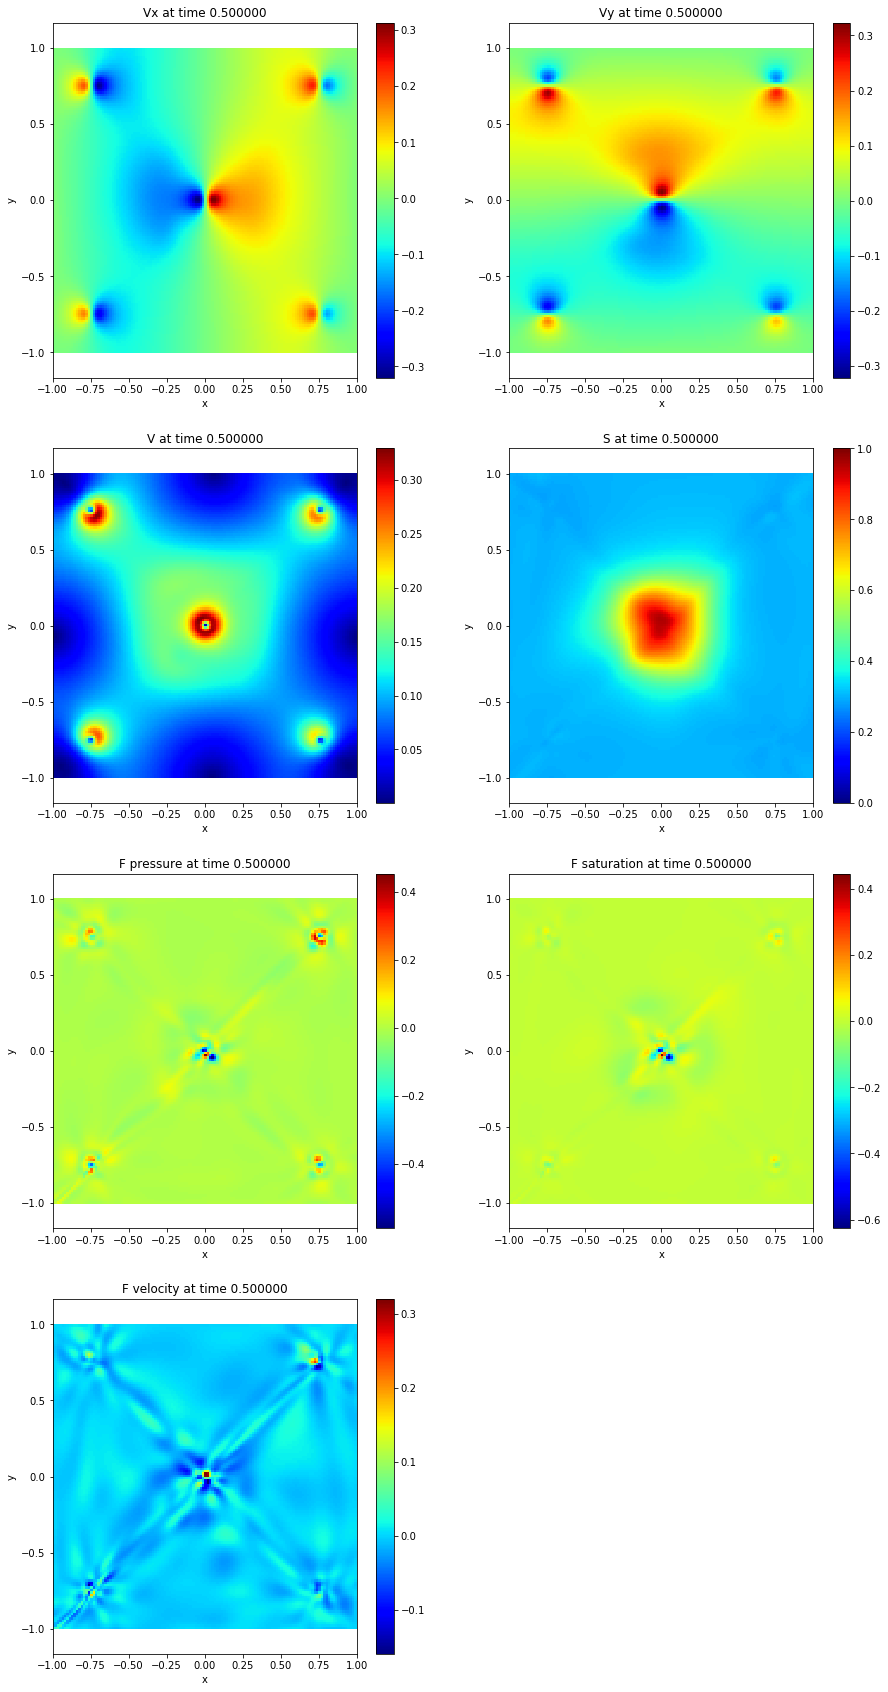

It: 0, Loss: 3.730e-04, Time: 1.11
It: 10, Loss: 3.721e-04, Time: 10.02
It: 20, Loss: 3.714e-04, Time: 9.96
It: 30, Loss: 3.709e-04, Time: 9.94
It: 40, Loss: 3.704e-04, Time: 9.97
It: 50, Loss: 3.700e-04, Time: 9.97
It: 60, Loss: 3.697e-04, Time: 11.13
It: 70, Loss: 3.694e-04, Time: 9.95
It: 80, Loss: 3.691e-04, Time: 9.95
It: 90, Loss: 3.688e-04, Time: 9.95
It: 100, Loss: 3.685e-04, Time: 10.00
It: 110, Loss: 3.683e-04, Time: 9.94
It: 120, Loss: 3.680e-04, Time: 9.90
It: 130, Loss: 3.678e-04, Time: 9.96
It: 140, Loss: 3.676e-04, Time: 9.95
It: 150, Loss: 3.673e-04, Time: 9.81
It: 160, Loss: 3.671e-04, Time: 9.93
It: 170, Loss: 3.669e-04, Time: 9.88
It: 180, Loss: 3.667e-04, Time: 9.85
It: 190, Loss: 3.665e-04, Time: 9.90
Iter: 00100, Loss: 3.53e-04, s: 4.272e-05, vx: 6.821e-06, vy: 6.908e-06, fp: 1.217e-04, fs: 1.057e-04, fv: 6.921e-05
Iter: 00200, Loss: 3.42e-04, s: 4.238e-05, vx: 6.678e-06, vy: 6.118e-06, fp: 1.173e-04, fs: 1.048e-04, fv: 6.480e-05
Iter: 00300, Loss: 3.32e-04, s: 4.

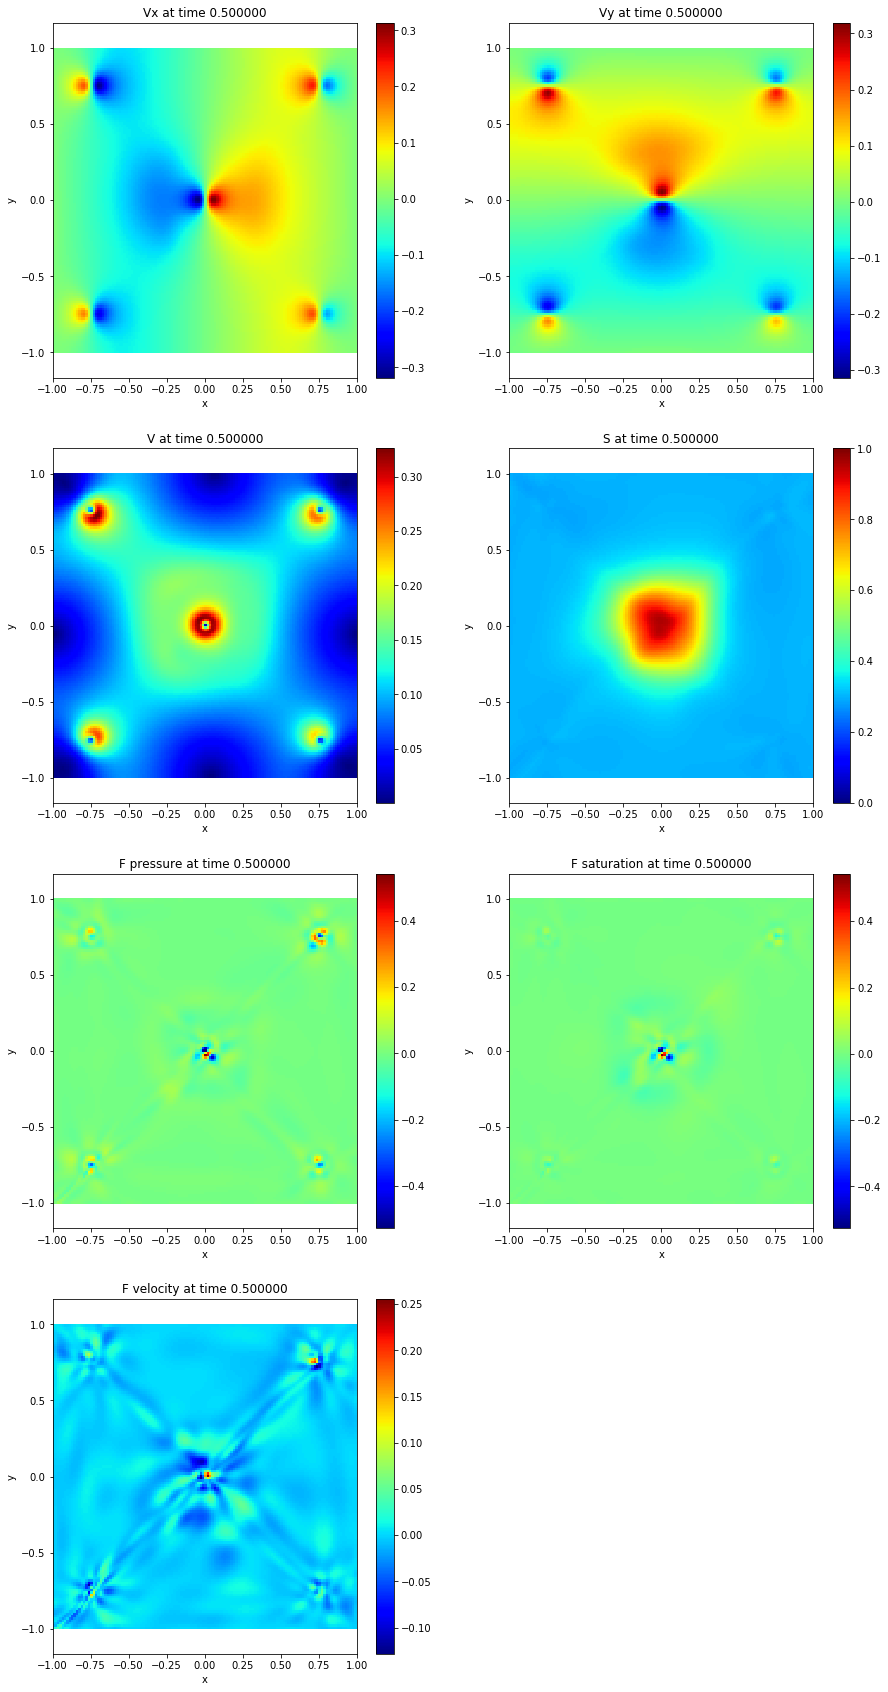

It: 0, Loss: 2.487e-04, Time: 1.23
It: 10, Loss: 2.482e-04, Time: 10.99
It: 20, Loss: 2.478e-04, Time: 12.13
It: 30, Loss: 2.475e-04, Time: 11.25
It: 40, Loss: 2.472e-04, Time: 10.40
It: 50, Loss: 2.469e-04, Time: 10.15
It: 60, Loss: 2.467e-04, Time: 10.19
It: 70, Loss: 2.465e-04, Time: 10.12
It: 80, Loss: 2.464e-04, Time: 10.16
It: 90, Loss: 2.462e-04, Time: 10.25
It: 100, Loss: 2.460e-04, Time: 10.30
It: 110, Loss: 2.459e-04, Time: 10.09
It: 120, Loss: 2.457e-04, Time: 10.10
It: 130, Loss: 2.456e-04, Time: 10.05
It: 140, Loss: 2.455e-04, Time: 10.03
It: 150, Loss: 2.453e-04, Time: 9.98
It: 160, Loss: 2.452e-04, Time: 10.02
It: 170, Loss: 2.451e-04, Time: 10.01
It: 180, Loss: 2.450e-04, Time: 10.06
It: 190, Loss: 2.449e-04, Time: 10.16
Iter: 00100, Loss: 2.38e-04, s: 2.538e-05, vx: 5.231e-06, vy: 4.298e-06, fp: 8.619e-05, fs: 7.360e-05, fv: 4.332e-05
Iter: 00200, Loss: 2.32e-04, s: 2.511e-05, vx: 4.894e-06, vy: 4.417e-06, fp: 8.471e-05, fs: 7.224e-05, fv: 4.072e-05
Iter: 00300, Loss: 

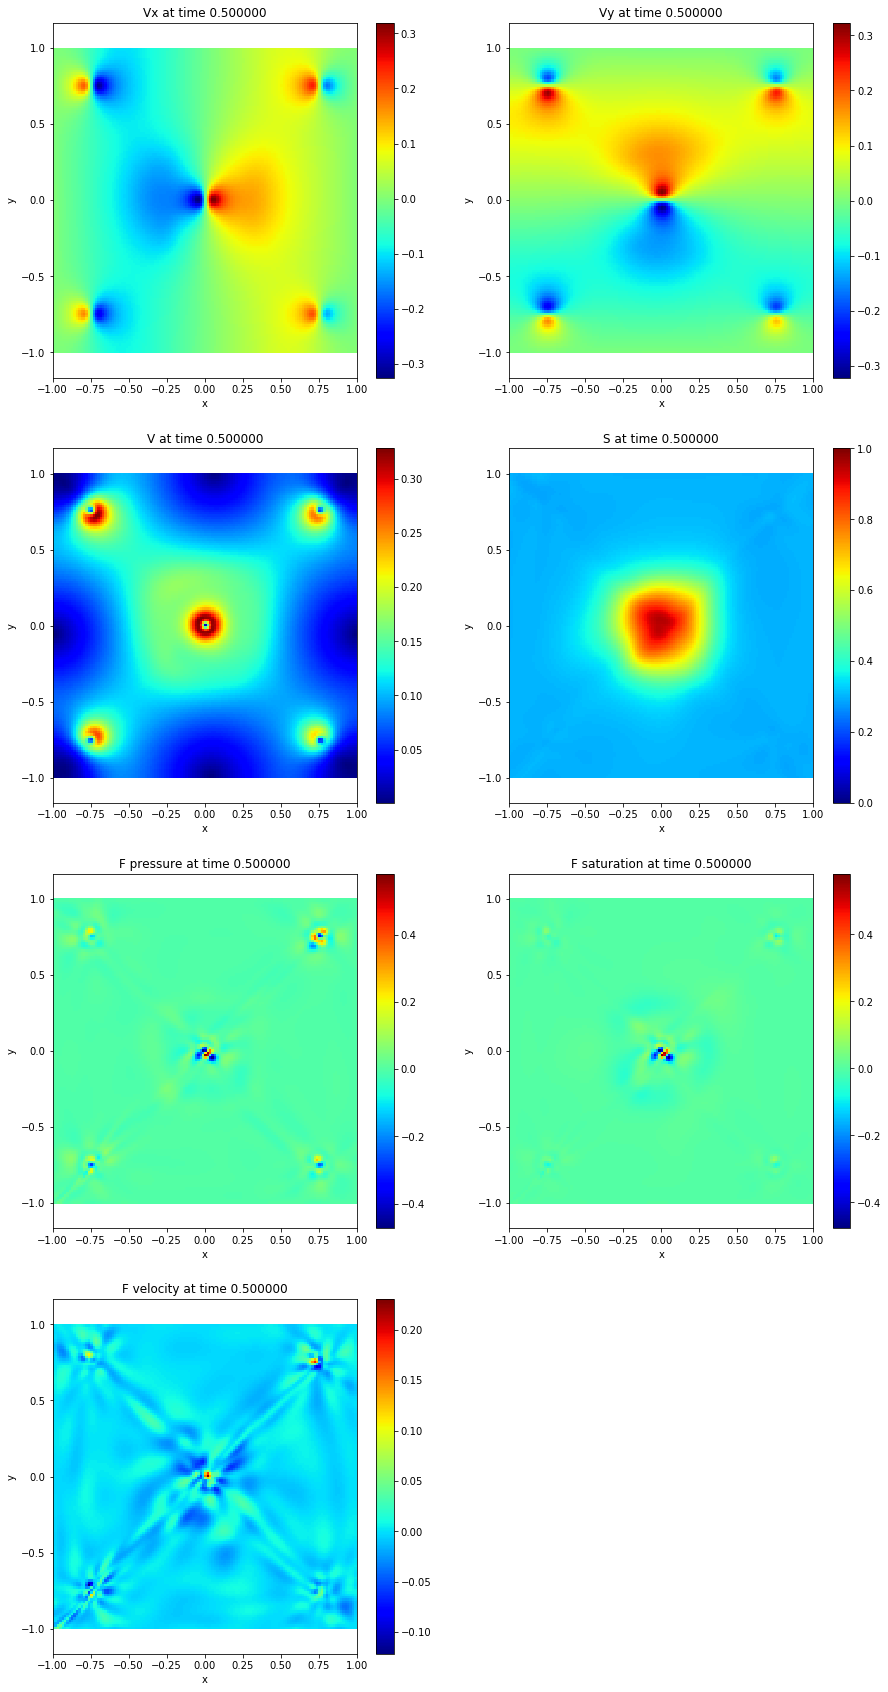

It: 0, Loss: 1.881e-04, Time: 0.99
Iter: 00100, Loss: 1.84e-04, s: 1.840e-05, vx: 3.902e-06, vy: 3.102e-06, fp: 6.964e-05, fs: 5.736e-05, fv: 3.184e-05
Iter: 00200, Loss: 1.81e-04, s: 1.820e-05, vx: 3.580e-06, vy: 3.010e-06, fp: 6.895e-05, fs: 5.697e-05, fv: 3.064e-05
Iter: 00300, Loss: 1.79e-04, s: 1.835e-05, vx: 3.635e-06, vy: 2.905e-06, fp: 6.788e-05, fs: 5.636e-05, fv: 2.978e-05
Iter: 00400, Loss: 1.77e-04, s: 1.817e-05, vx: 3.530e-06, vy: 3.058e-06, fp: 6.739e-05, fs: 5.573e-05, fv: 2.879e-05
Iter: 00500, Loss: 1.74e-04, s: 1.802e-05, vx: 3.621e-06, vy: 2.969e-06, fp: 6.596e-05, fs: 5.566e-05, fv: 2.811e-05
Iter: 00600, Loss: 1.71e-04, s: 1.791e-05, vx: 3.556e-06, vy: 2.887e-06, fp: 6.505e-05, fs: 5.451e-05, fv: 2.748e-05
Iter: 00700, Loss: 1.68e-04, s: 1.720e-05, vx: 3.491e-06, vy: 2.793e-06, fp: 6.371e-05, fs: 5.317e-05, fv: 2.755e-05
Iter: 00800, Loss: 1.63e-04, s: 1.598e-05, vx: 3.500e-06, vy: 2.457e-06, fp: 6.260e-05, fs: 5.109e-05, fv: 2.750e-05
Iter: 00900, Loss: 1.60e-04, 

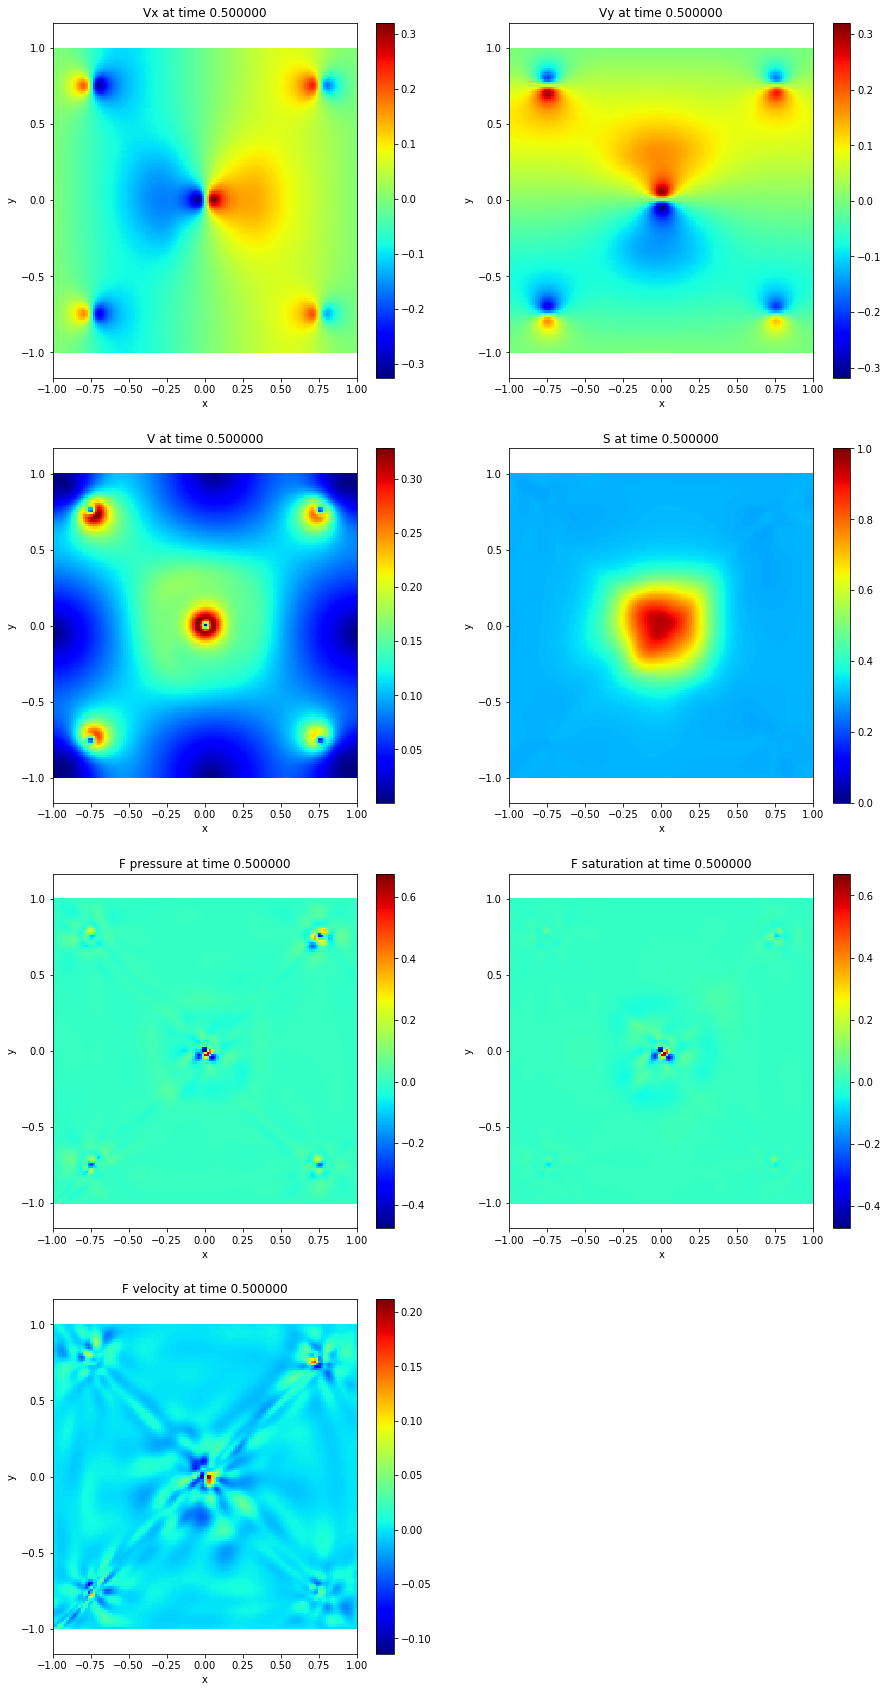

It: 0, Loss: 1.548e-04, Time: 0.97
Iter: 00100, Loss: 1.53e-04, s: 1.470e-05, vx: 3.157e-06, vy: 2.210e-06, fp: 5.928e-05, fs: 4.672e-05, fv: 2.660e-05
Iter: 00200, Loss: 1.50e-04, s: 1.439e-05, vx: 3.084e-06, vy: 2.179e-06, fp: 5.845e-05, fs: 4.660e-05, fv: 2.554e-05
Iter: 00300, Loss: 1.47e-04, s: 1.420e-05, vx: 2.896e-06, vy: 2.220e-06, fp: 5.706e-05, fs: 4.623e-05, fv: 2.448e-05
Iter: 00400, Loss: 1.44e-04, s: 1.427e-05, vx: 2.762e-06, vy: 2.191e-06, fp: 5.604e-05, fs: 4.552e-05, fv: 2.337e-05
Iter: 00500, Loss: 1.42e-04, s: 1.394e-05, vx: 2.758e-06, vy: 2.099e-06, fp: 5.503e-05, fs: 4.520e-05, fv: 2.290e-05
Iter: 00600, Loss: 1.40e-04, s: 1.360e-05, vx: 2.661e-06, vy: 2.044e-06, fp: 5.500e-05, fs: 4.407e-05, fv: 2.268e-05
Iter: 00700, Loss: 1.39e-04, s: 1.327e-05, vx: 2.662e-06, vy: 1.942e-06, fp: 5.456e-05, fs: 4.359e-05, fv: 2.253e-05
Iter: 00800, Loss: 1.37e-04, s: 1.298e-05, vx: 2.656e-06, vy: 1.895e-06, fp: 5.421e-05, fs: 4.309e-05, fv: 2.244e-05
Iter: 00900, Loss: 1.36e-04, 

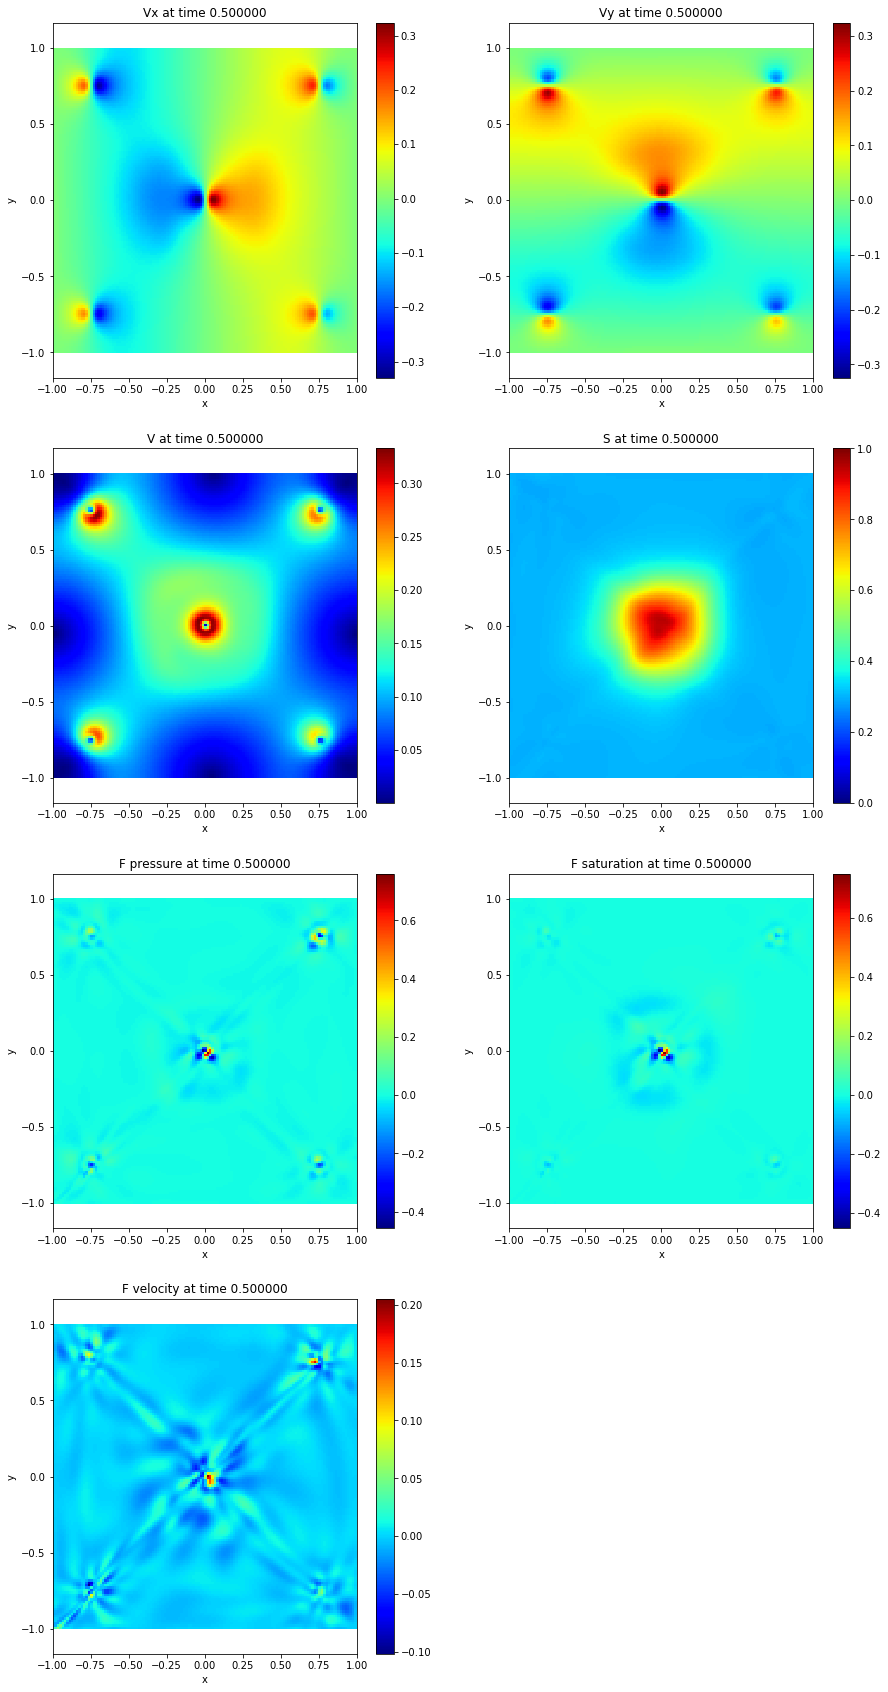

It: 0, Loss: 1.319e-04, Time: 0.96
Iter: 00100, Loss: 1.30e-04, s: 1.205e-05, vx: 2.712e-06, vy: 1.710e-06, fp: 5.081e-05, fs: 4.083e-05, fv: 2.202e-05
Iter: 00200, Loss: 1.29e-04, s: 1.180e-05, vx: 2.523e-06, vy: 1.676e-06, fp: 5.078e-05, fs: 4.039e-05, fv: 2.146e-05
Iter: 00300, Loss: 1.28e-04, s: 1.173e-05, vx: 2.484e-06, vy: 1.656e-06, fp: 5.029e-05, fs: 4.029e-05, fv: 2.113e-05
Iter: 00400, Loss: 1.26e-04, s: 1.171e-05, vx: 2.443e-06, vy: 1.719e-06, fp: 4.971e-05, fs: 3.996e-05, fv: 2.063e-05
Iter: 00500, Loss: 1.25e-04, s: 1.153e-05, vx: 2.461e-06, vy: 1.695e-06, fp: 4.901e-05, fs: 3.974e-05, fv: 2.038e-05
Iter: 00600, Loss: 1.23e-04, s: 1.141e-05, vx: 2.468e-06, vy: 1.658e-06, fp: 4.829e-05, fs: 3.939e-05, fv: 2.008e-05
Iter: 00700, Loss: 1.22e-04, s: 1.135e-05, vx: 2.409e-06, vy: 1.691e-06, fp: 4.766e-05, fs: 3.863e-05, fv: 2.006e-05
Iter: 00800, Loss: 1.20e-04, s: 1.086e-05, vx: 2.351e-06, vy: 1.560e-06, fp: 4.765e-05, fs: 3.754e-05, fv: 2.002e-05
Iter: 00900, Loss: 1.18e-04, 

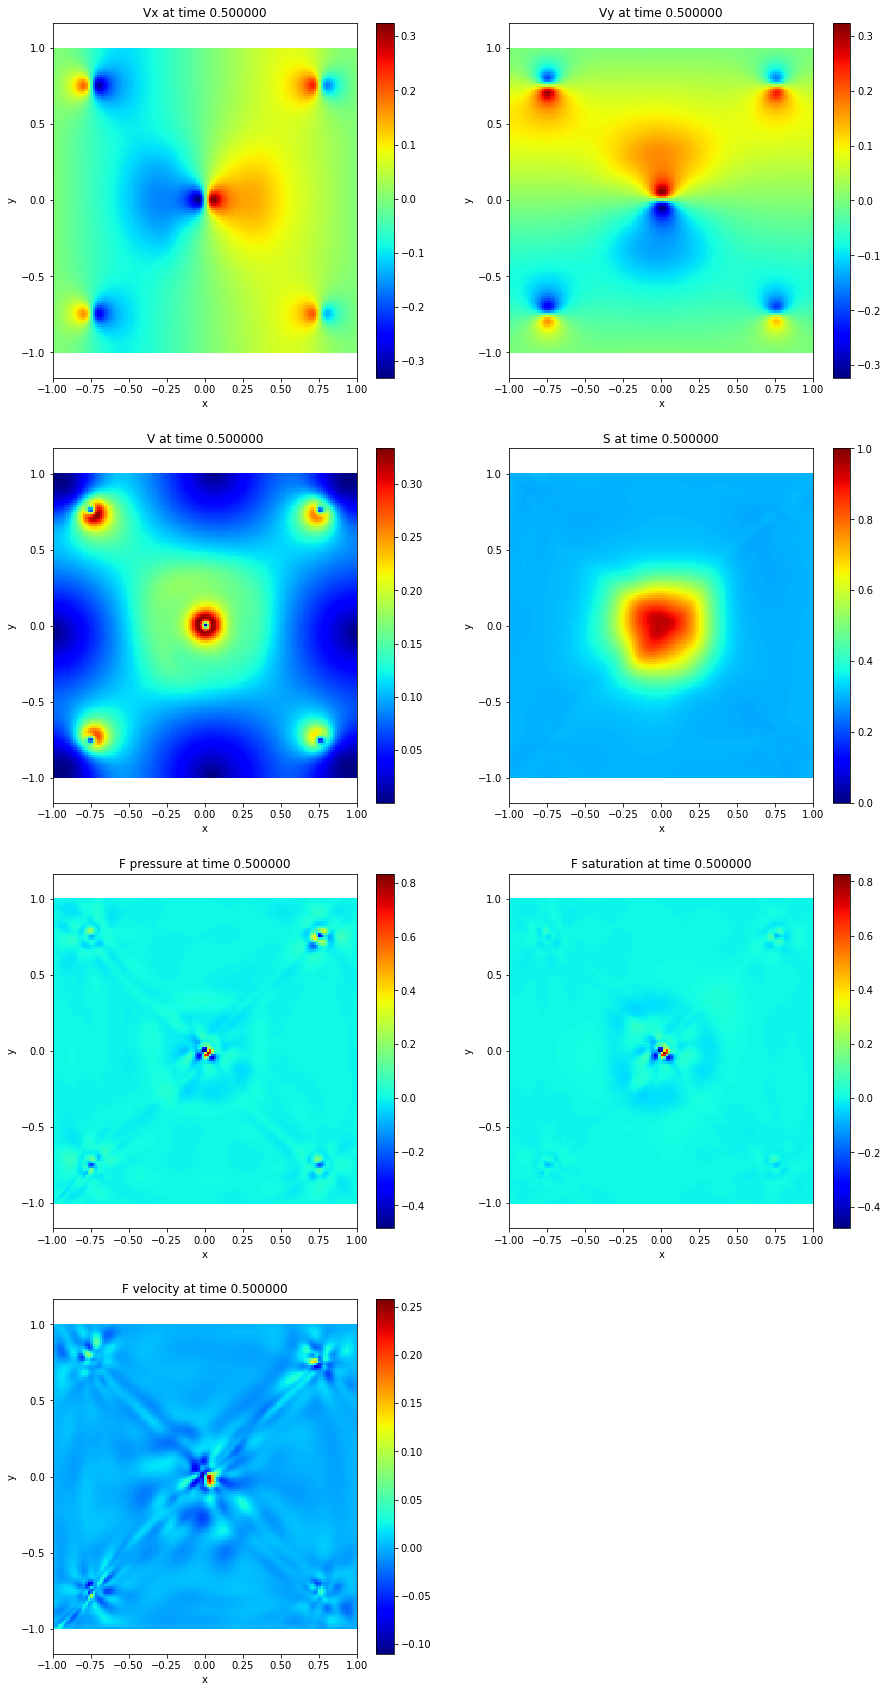

It: 0, Loss: 1.154e-04, Time: 1.00
Iter: 00100, Loss: 1.14e-04, s: 1.034e-05, vx: 2.168e-06, vy: 1.397e-06, fp: 4.550e-05, fs: 3.491e-05, fv: 1.991e-05
Iter: 00200, Loss: 1.13e-04, s: 1.012e-05, vx: 2.163e-06, vy: 1.410e-06, fp: 4.496e-05, fs: 3.487e-05, fv: 1.925e-05
Iter: 00300, Loss: 1.11e-04, s: 1.015e-05, vx: 2.086e-06, vy: 1.400e-06, fp: 4.421e-05, fs: 3.448e-05, fv: 1.877e-05
Iter: 00400, Loss: 1.09e-04, s: 1.004e-05, vx: 2.073e-06, vy: 1.370e-06, fp: 4.318e-05, fs: 3.447e-05, fv: 1.834e-05
Iter: 00500, Loss: 1.08e-04, s: 9.745e-06, vx: 2.047e-06, vy: 1.301e-06, fp: 4.292e-05, fs: 3.408e-05, fv: 1.808e-05
Iter: 00600, Loss: 1.07e-04, s: 9.668e-06, vx: 1.997e-06, vy: 1.299e-06, fp: 4.265e-05, fs: 3.353e-05, fv: 1.791e-05
Iter: 00700, Loss: 1.06e-04, s: 9.421e-06, vx: 2.004e-06, vy: 1.271e-06, fp: 4.249e-05, fs: 3.314e-05, fv: 1.782e-05


KeyboardInterrupt: 

In [25]:
for i in range(10):
    start_time = time.time()
    if i<3:
        model.train(200)
    else:
        model.train(10)
    elapsed = time.time() - start_time
    print('Training time: %.4f' % (elapsed))
    draw_prediction(0.5)

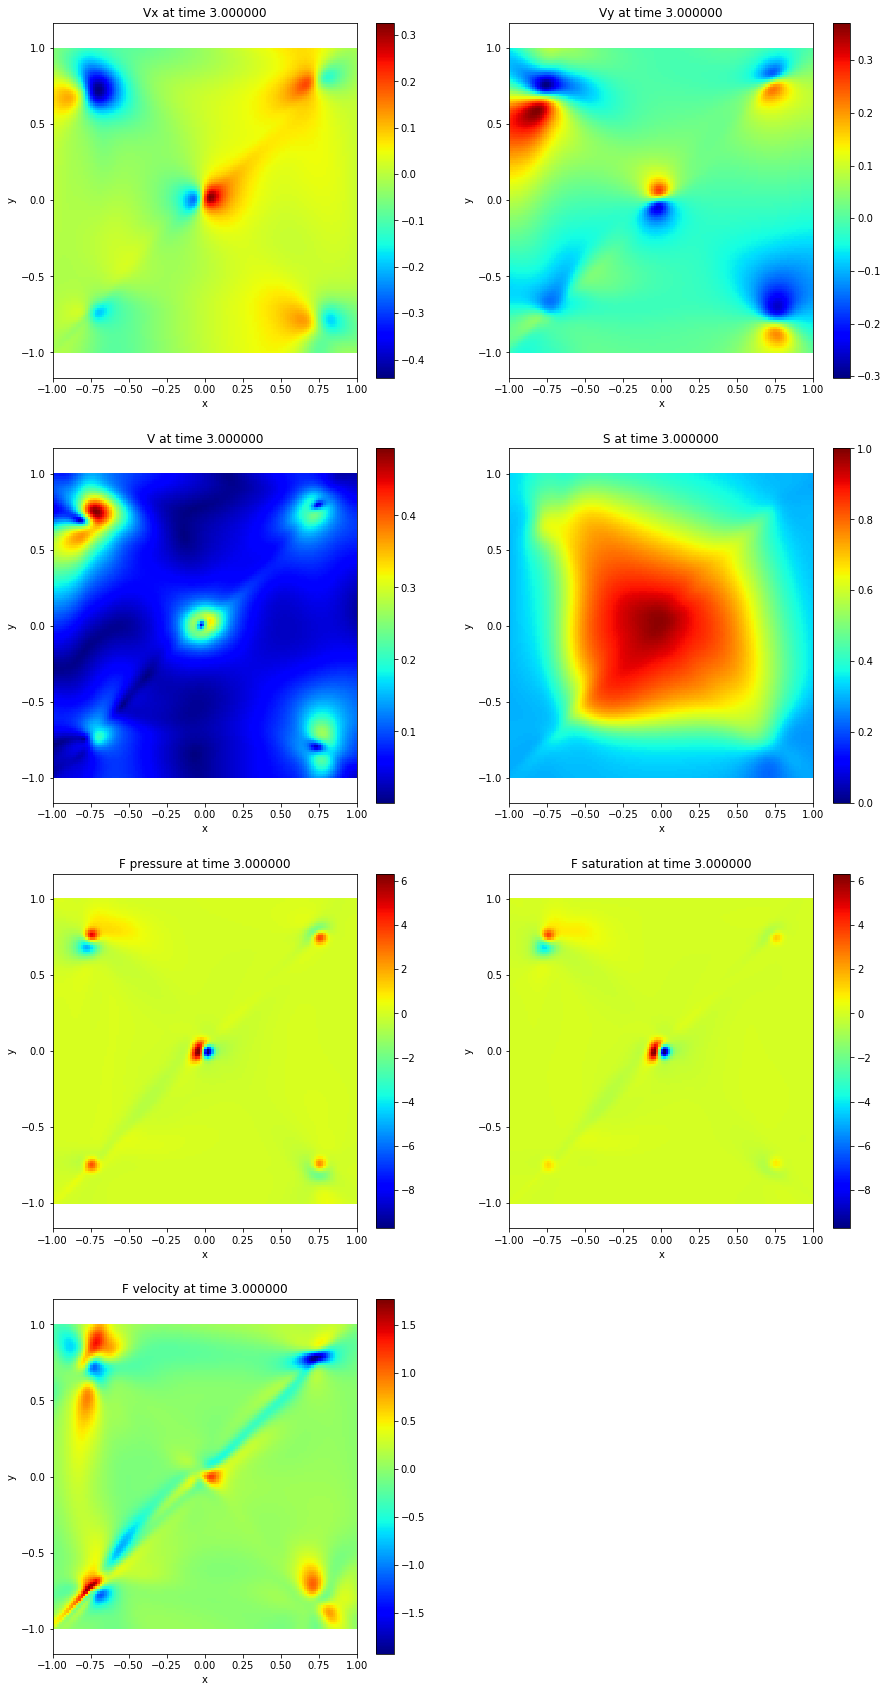

In [32]:
draw_prediction(3)